# Classification Algorithms and their Comparison

Classification algorithms are Supervised Machine Learning Algorithms that are used when the data to be predicted belongs to a categorical dataset.

Some Classification Algorithms are as follows:

1. [Naive Bayes](#Naive-Bayes)
2. [Logistic Regression](#Logistic-Regression)
3. [K Neighbors Classifier](#K-Neighbors-Classifier)
4. [Support Vector Machines](#Support-Vector-Machines)
5. [Ensemble Methods](#Ensemble-Methods)

    5.1. [Random Forest](#Random-Forest)

    5.2. [Gradient Boosted Trees](#Gradient-Boosted-Trees)

## Importing Libraries

In [306]:
import sys
import io

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd, numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

## Loading & Exploring Dataset

In [307]:
df_churn_pd = pd.read_csv(
    "https://raw.githubusercontent.com/IBM/ml-learning-path-assets/master/data/mergedcustomers_missing_values_GENDER.csv")
df_churn_pd.sample(2)

,ID,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
482,119,High,F,S,2,57420.0,Y,61,25182.52,252,12591.260,1259.1260,63.00,1,7,0.0,1259.1260
1322,1371,Medium,F,M,2,98217.1,N,45,29492.95,13,14746.475,1474.6475,3.25,3,8,0.0,1474.6475


In [308]:
print("Basic dataset info :")
print(df_churn_pd.info())

Basic dataset info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         2066 non-null   int64  
 1   CHURNRISK                  2066 non-null   object 
 2   GENDER                     2063 non-null   object 
 3   STATUS                     2066 non-null   object 
 4   CHILDREN                   2066 non-null   int64  
 5   ESTINCOME                  2066 non-null   float64
 6   HOMEOWNER                  2066 non-null   object 
 7   AGE                        2066 non-null   int64  
 8   TOTALDOLLARVALUETRADED     2066 non-null   float64
 9   TOTALUNITSTRADED           2066 non-null   int64  
 10  LARGESTSINGLETRANSACTION   2066 non-null   float64
 11  SMALLESTSINGLETRANSACTION  2066 non-null   float64
 12  PERCENTCHANGECALCULATION   2066 non-null   float64
 13  DAYSSINCELASTLOGIN         

The Gender column has 3 Null Values.

To explicity view the null values, we can run the following code:

In [309]:
print("Null Values in Each Column : \n" +str(df_churn_pd.isnull().sum()))

Null Values in Each Column : 
ID                           0
CHURNRISK                    0
GENDER                       3
STATUS                       0
CHILDREN                     0
ESTINCOME                    0
HOMEOWNER                    0
AGE                          0
TOTALDOLLARVALUETRADED       0
TOTALUNITSTRADED             0
LARGESTSINGLETRANSACTION     0
SMALLESTSINGLETRANSACTION    0
PERCENTCHANGECALCULATION     0
DAYSSINCELASTLOGIN           0
DAYSSINCELASTTRADE           0
NETREALIZEDGAINS_YTD         0
NETREALIZEDLOSSES_YTD        0
dtype: int64


## Frequency chart of Churn Risk

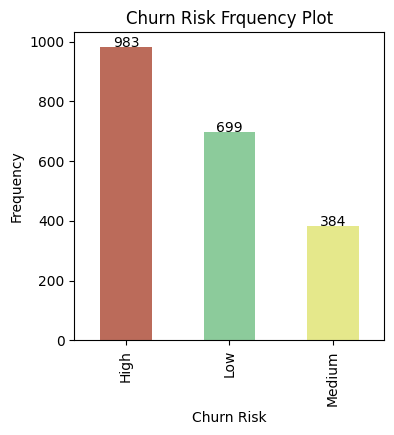

In [310]:
series_churnrisk_pd = df_churn_pd['CHURNRISK'].value_counts(sort=True, ascending=False)
churn_plot = series_churnrisk_pd.plot(kind='bar',
            figsize=(4,4),title="Churn Risk Frquency Plot", color=['#BB6B5A','#8CCB9B','#E5E88B'])
for i in range(len(series_churnrisk_pd)):
        churn_plot.text(i, series_churnrisk_pd.values[i], series_churnrisk_pd.values[i], ha = 'center')
churn_plot.set_xlabel("Churn Risk")
churn_plot.set_ylabel("Frequency");

## Data Preparation

In [311]:
#remove columns that are not required
df_churn_pd = df_churn_pd.drop(['ID'], axis=1)

df_churn_pd.sample()

,CHURNRISK,GENDER,STATUS,CHILDREN,ESTINCOME,HOMEOWNER,AGE,TOTALDOLLARVALUETRADED,TOTALUNITSTRADED,LARGESTSINGLETRANSACTION,SMALLESTSINGLETRANSACTION,PERCENTCHANGECALCULATION,DAYSSINCELASTLOGIN,DAYSSINCELASTTRADE,NETREALIZEDGAINS_YTD,NETREALIZEDLOSSES_YTD
292,High,M,D,1,84166.1,N,33,3280.33,11,820.0825,82.00825,1.65,5,17,0.0,164.0165


Gender has 3 missing values.

We will use [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to fill in the missing values by the `most_frequent` value in the series.

Columns such as GENDER, STATUS and HOMEOWNER are categorical columns. We can convert them into numbers using `OneHotEncoder` for better performance.

In [312]:
# Defining the categorical columns
categoricalColumns = ['GENDER', 'STATUS', 'HOMEOWNER']

print("Categorical columns : " )
print(categoricalColumns)

impute_categorical = SimpleImputer(strategy="most_frequent")

onehot_categorical =  OneHotEncoder(handle_unknown='ignore')

categorical_transformer = Pipeline(steps=[('impute',impute_categorical),('onehot',onehot_categorical)])

Categorical columns : 
['GENDER', 'STATUS', 'HOMEOWNER']


The numerical columns from the data set are identified, and `StandardScaler` is applied to each of the columns. This way, each value is subtracted with the mean of its column and divided by its standard deviation.

In [313]:
# Defining the numerical columns
numericalColumns = df_churn_pd.select_dtypes(include=[float,int]).columns

print("Numerical columns : " )
print(numericalColumns)

scaler_numerical = StandardScaler()

numerical_transformer = Pipeline(steps=[('scale',scaler_numerical)])

Numerical columns : 
Index(['CHILDREN', 'ESTINCOME', 'AGE', 'TOTALDOLLARVALUETRADED',
       'TOTALUNITSTRADED', 'LARGESTSINGLETRANSACTION',
       'SMALLESTSINGLETRANSACTION', 'PERCENTCHANGECALCULATION',
       'DAYSSINCELASTLOGIN', 'DAYSSINCELASTTRADE', 'NETREALIZEDGAINS_YTD',
       'NETREALIZEDLOSSES_YTD'],
      dtype='object')


 Each of the techniques are grouped by the columns they needed to be applied on and are queued using the `ColumnTransformer`.

 Ideally, this is run in the pipeline just before the model is trained.

 However, to understand what the data will look like, we have transformed the data into a temporary variable.

In [314]:
preprocessorForCategoricalColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns)],
                                            remainder="passthrough")

preprocessorForAllColumns = ColumnTransformer(transformers=[('cat', categorical_transformer, categoricalColumns),
                                                            ('num',numerical_transformer,numericalColumns)],
                                            remainder="passthrough")


df_churn_pd_temp = preprocessorForCategoricalColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp)

df_churn_pd_temp_2 = preprocessorForAllColumns.fit_transform(df_churn_pd)
print("Data after transforming :")
print(df_churn_pd_temp_2)

Data after transforming :
[[1.0 0.0 0.0 ... 13 0.0 152.76525]
 [1.0 0.0 0.0 ... 10 1349.635 0.0]
 [1.0 0.0 0.0 ... 5 1123.6125 0.0]
 ...
 [1.0 0.0 0.0 ... 11 0.0 82.50825]
 [1.0 0.0 0.0 ... 5 930.093 0.0]
 [0.0 1.0 0.0 ... 8 1041.604 0.0]]
Data after transforming :
[[1.0 0.0 0.0 ... -0.6792731303453047 -0.5106065181930338 'Medium']
 [1.0 0.0 0.0 ... 1.8354629319820521 -0.7959345330293706 'Low']
 [1.0 0.0 0.0 ... 1.4143217110983428 -0.7959345330293706 'Low']
 ...
 [1.0 0.0 0.0 ... -0.6792731303453047 -0.6418293606808149 'Medium']
 [1.0 0.0 0.0 ... 1.053742394902809 -0.7959345330293706 'Low']
 [0.0 1.0 0.0 ... 1.261517632686496 -0.7959345330293706 'Low']]


We need to convert the Churn Risk column values from str to numerical.

Each str in the churn risk column, represents a category, which is identified by a numerical label.

This is done using [`Label Encoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html).

In [315]:
# prepare data frame for splitting data into train and test datasets

features = []
features = df_churn_pd.drop(['CHURNRISK'], axis=1)

label_encoder = LabelEncoder()
label = df_churn_pd['CHURNRISK']

label = label_encoder.fit_transform(label)

org_labels = label_encoder.inverse_transform(sorted(np.unique(label)))

print("Encoding : ")
for i in range(len(org_labels)):
  print(str(i)+" - "+org_labels[i])

print("\nEncoded value of Churnrisk after applying label encoder : " + str(label))

Encoding : 
0 - High
1 - Low
2 - Medium

Encoded value of Churnrisk after applying label encoder : [2 1 1 ... 2 1 1]


## Pie Chart of Gender

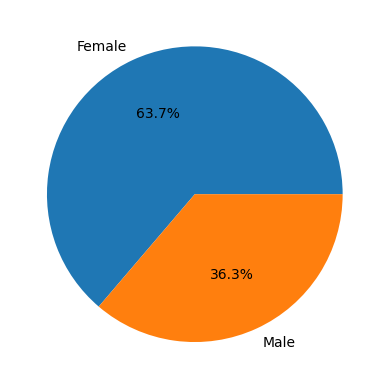

In [316]:
series_gender_pd = df_churn_pd["GENDER"].value_counts()
series_gender_pd.rename(index={'M':'Male', 'F':'Female'}, inplace=True)
fig, ax = plt.subplots()
ax.pie(series_gender_pd, autopct='%1.1f%%', labels = series_gender_pd.index)
plt.show()

## Churn Risk graphs based on
- Days since last trade
- Estimated Income
- Total Value Traded

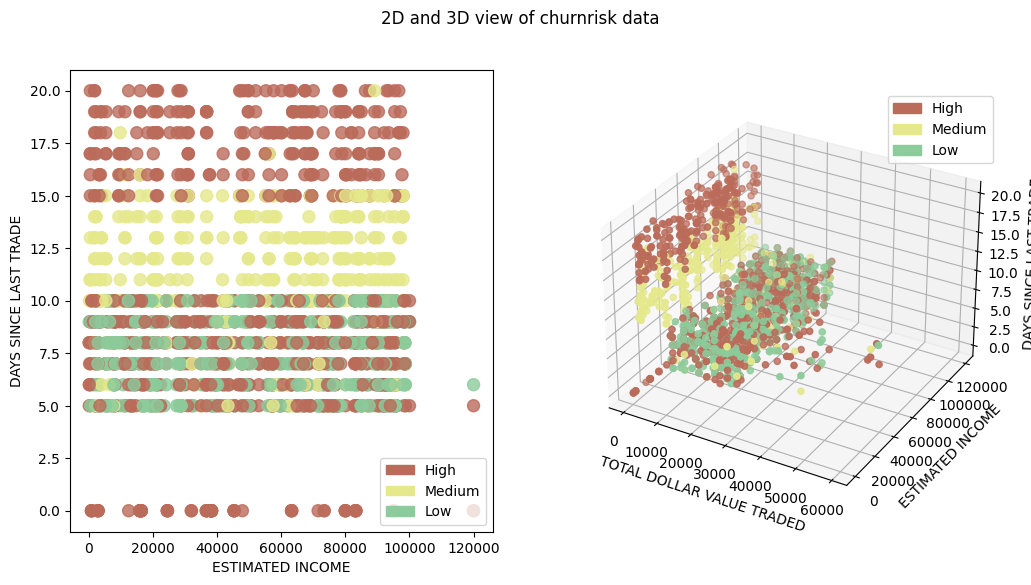

In [317]:
area = 75
x = df_churn_pd['ESTINCOME']
y = df_churn_pd['DAYSSINCELASTTRADE']
z = df_churn_pd['TOTALDOLLARVALUETRADED']

pop_a = mpatches.Patch(color='#BB6B5A', label='High')
pop_b = mpatches.Patch(color='#E5E88B', label='Medium')
pop_c = mpatches.Patch(color='#8CCB9B', label='Low')
def colormap(risk_list):
    cols=[]
    for l in risk_list:
        if l==0:
            cols.append('#BB6B5A')
        elif l==2:
            cols.append('#E5E88B')
        elif l==1:
            cols.append('#8CCB9B')
    return cols

fig = plt.figure(figsize=(12,6))
fig.suptitle('2D and 3D view of churnrisk data')

# First subplot
ax = fig.add_subplot(1, 2,1)

ax.scatter(x, y, alpha=0.8, c=colormap(label), s= area)
ax.set_ylabel('DAYS SINCE LAST TRADE')
ax.set_xlabel('ESTIMATED INCOME')

plt.legend(handles=[pop_a,pop_b,pop_c])

# Second subplot
ax = fig.add_subplot(1,2,2, projection='3d')

ax.scatter(z, x, y, c=colormap(label), marker='o')

ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
ax.set_ylabel('ESTIMATED INCOME')
ax.set_zlabel('DAYS SINCE LAST TRADE')

plt.legend(handles=[pop_a,pop_b,pop_c])

plt.show()

## Splitting Training and Testing Data

[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function parameters :

features = input variables

label = output variables

test_size = proportion of data to be used for testing

random_sate = a number that tells sklean how to split data

In [318]:
X_train, X_test, y_train, y_test = train_test_split(features, label , test_size=0.20, random_state=0)
print("Dimensions of datasets that will be used for training : Input features"+str(X_train.shape)+
      " Output label" + str(y_train.shape))
print("Dimensions of datasets that will be used for testing : Input features"+str(X_test.shape)+
      " Output label" + str(y_test.shape))

Dimensions of datasets that will be used for training : Input features(1652, 15) Output label(1652,)
Dimensions of datasets that will be used for testing : Input features(414, 15) Output label(414,)


## Functions for Graph

In [319]:
def colormap(risk_list):
    cols=[]
    for l in risk_list:
        if l==0:
            cols.append('#BB6B5A')
        elif l==2:
            cols.append('#E5E88B')
        elif l==1:
            cols.append('#8CCB9B')
    return cols

def two_d_compare(y_test,y_pred,model_name):
    #y_pred = label_encoder.fit_transform(y_pred)
    #y_test = label_encoder.fit_transform(y_test)
    area = (12 * np.random.rand(40))**2
    plt.subplots(ncols=2, figsize=(10,4))
    plt.suptitle('Actual vs Predicted data : ' +model_name + '. Accuracy : %.2f' % accuracy_score(y_test, y_pred))

    plt.subplot(121)
    plt.scatter(X_test['ESTINCOME'], X_test['DAYSSINCELASTTRADE'], alpha=0.8, c=colormap(y_test))
    plt.title('Actual')
    plt.legend(handles=[pop_a,pop_b,pop_c])

    plt.subplot(122)
    plt.scatter(X_test['ESTINCOME'], X_test['DAYSSINCELASTTRADE'],alpha=0.8, c=colormap(y_pred))
    plt.title('Predicted')
    plt.legend(handles=[pop_a,pop_b,pop_c])

    plt.show()

x = X_test['TOTALDOLLARVALUETRADED']
y = X_test['ESTINCOME']
z = X_test['DAYSSINCELASTTRADE']

pop_a = mpatches.Patch(color='#BB6B5A', label='High')
pop_b = mpatches.Patch(color='#E5E88B', label='Medium')
pop_c = mpatches.Patch(color='#8CCB9B', label='Low')

def three_d_compare(y_test,y_pred,model_name):
    fig = plt.figure(figsize=(12,10))
    fig.suptitle('Actual vs Predicted (3D) data : ' +model_name + '. Accuracy : %.2f' % accuracy_score(y_test, y_pred))

    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=colormap(y_test), marker='o')
    ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
    ax.set_ylabel('ESTIMATED INCOME')
    ax.set_zlabel('DAYS SINCE LAST TRADE')
    plt.legend(handles=[pop_a,pop_b,pop_c])
    plt.title('Actual')

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(x, y, z, c=colormap(y_pred), marker='o')
    ax.set_xlabel('TOTAL DOLLAR VALUE TRADED')
    ax.set_ylabel('ESTIMATED INCOME')
    ax.set_zlabel('DAYS SINCE LAST TRADE')
    plt.legend(handles=[pop_a,pop_b,pop_c])
    plt.title('Predicted')

    plt.show()


def model_metrics(y_test,y_pred):

    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels = org_labels)
    cm_display.plot()
    plt.show()

    print("The classification report for the model : \n\n"+ classification_report(y_test, y_pred))

## [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)

- Uses Bayes' theorem

  `P(a|B) = ( P(B|a) * P(a) ) / P(B)`

- Naive Bayes Algorithm assumes conditional independence between all pairs of features

- In the above equation, let `a` be the class variable to be predicted, and `B` be the dependent feature vector

<!--- It can be further written as :-->

- `P(a)` can be estimated by finding the relative frequency of class `a` in the training set

- Different Naive Bayes classifiers uses different ways to estimate `P(B|a)`

- Here we will use Multinomial Naive Bayes Algorithm

  `P(b|a) = (N_ab + α) / (N_a + αn)`

  `b` = a feature in the feature vector `B`

  `N_ab` = number of times feature `b` appears in class `a`

  `N_a` = total count of all features of class `b`

  `α` = Smoothing parameter

  `n` = total number of features in `B`

In [320]:
from sklearn.naive_bayes import MultinomialNB

model_name = 'Naive Bayes Classifier'

nbClassifier = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

nb_model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),('classifier', nbClassifier)])

nb_model.fit(X_train,y_train)

y_pred_nb= nb_model.predict(X_test)

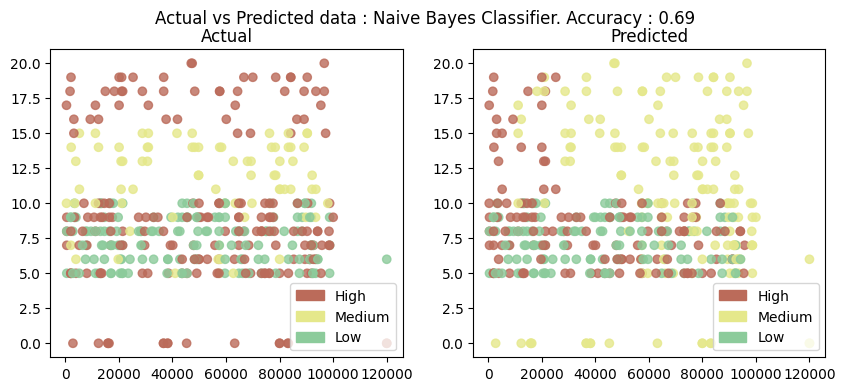

In [321]:
two_d_compare(y_test,y_pred_nb,model_name)


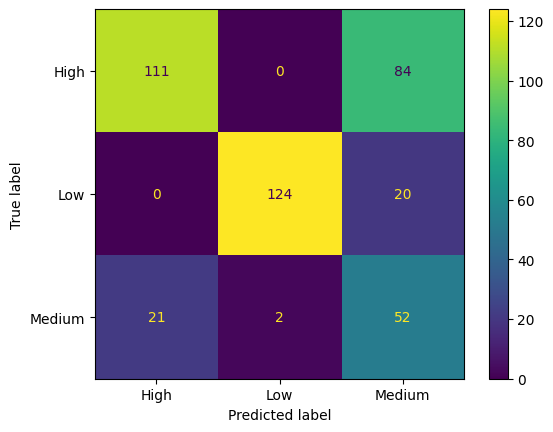

The classification report for the model : 

              precision    recall  f1-score   support

        High       0.84      0.57      0.68       195
         Low       0.98      0.86      0.92       144
      Medium       0.33      0.69      0.45        75

    accuracy                           0.69       414
   macro avg       0.72      0.71      0.68       414
weighted avg       0.80      0.69      0.72       414



In [322]:
y_test = label_encoder.inverse_transform(y_test)
y_pred_nb = label_encoder.inverse_transform(y_pred_nb)
model_metrics(y_test,y_pred_nb)

## [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

- Logistic / Sigmoid function is applied to the output of linear regression.

- The logistic function outputs a value between 0 and 1.

- We then select slect a line to classify a data point as 0 or 1.

In [323]:
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression Classifier"

logisticRegressionClassifier = LogisticRegression(random_state=0,multi_class='auto',solver='lbfgs',max_iter=1000)

lrc_model = Pipeline(steps=[('preprocessor', preprocessorForCategoricalColumns),
                            ('classifier', logisticRegressionClassifier)])

lrc_model.fit(X_train,y_train)

y_pred_lrc = lrc_model.predict(X_test)

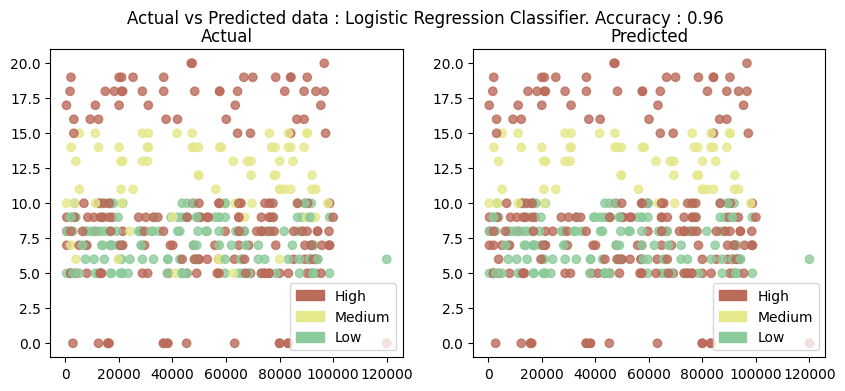

In [324]:
y_test = label_encoder.transform(y_test)
two_d_compare(y_test,y_pred_lrc,model_name)

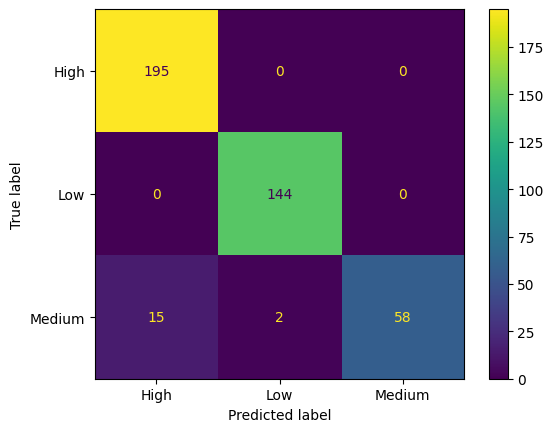

The classification report for the model : 

              precision    recall  f1-score   support

        High       0.93      1.00      0.96       195
         Low       0.99      1.00      0.99       144
      Medium       1.00      0.77      0.87        75

    accuracy                           0.96       414
   macro avg       0.97      0.92      0.94       414
weighted avg       0.96      0.96      0.96       414



In [325]:
y_test = label_encoder.inverse_transform(y_test)
y_pred_lrc = label_encoder.inverse_transform(y_pred_lrc)
model_metrics(y_test,y_pred_lrc)

## [K Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

- In order to classify a data point, its K nearest neighbors are identified

- These K neighbors already belong to a class

- The majority class of these neighbors is used to classify the data point under consideration

- The main idea of K Nearest Neighbors (KNN) is to predict data point's class using the majority class around it.

- Euclidean method of calculating distance can be used here

In [326]:
from sklearn.neighbors import KNeighborsClassifier

model_name = "K-Nearest Neighbor Classifier"

knnClassifier = KNeighborsClassifier(n_neighbors = 5, metric='minkowski', p=2)

knn_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('classifier', knnClassifier)])

knn_model.fit(X_train,y_train)

y_pred_knn = knn_model.predict(X_test)

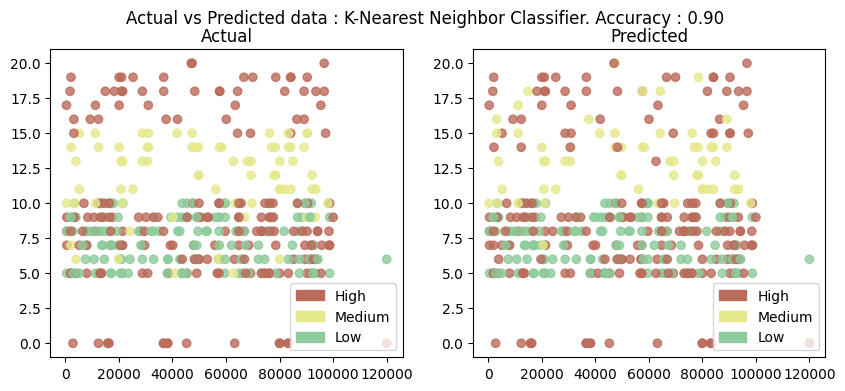

In [327]:
y_test = label_encoder.transform(y_test)
two_d_compare(y_test,y_pred_knn,model_name)

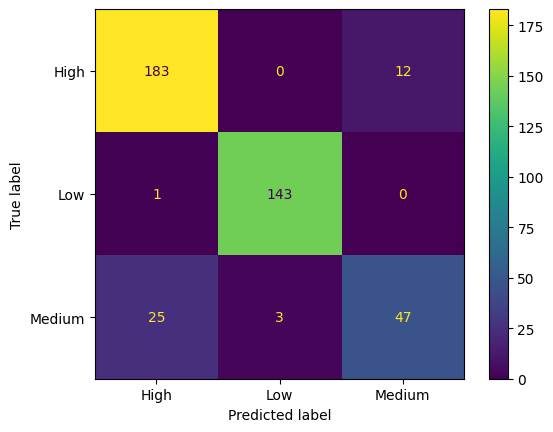

The classification report for the model : 

              precision    recall  f1-score   support

        High       0.88      0.94      0.91       195
         Low       0.98      0.99      0.99       144
      Medium       0.80      0.63      0.70        75

    accuracy                           0.90       414
   macro avg       0.88      0.85      0.86       414
weighted avg       0.90      0.90      0.90       414



In [328]:
y_test = label_encoder.inverse_transform(y_test)
y_pred_knn = label_encoder.inverse_transform(y_pred_knn)
model_metrics(y_test,y_pred_knn)

## [Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)

- Support Vector Machines (SVM) draws a line which devides the space into different regions belonging to different classes.

- This line is called as a hyperplane in multi-dimensional space.

- SVM also takes care of outliners that lie pretty close to other classes.

- The prediction is made by identifying the region, the data point lie in, and the corresponding class belonging to that region

- When linear separation is not possible and we need to map to a higher dimensional space, we use a kernel function

- Here, we will use the Gausian radial basis function (rbf) as the kernel function

- Prediction is made by identifying weather the point lies within or outside the plane.

In [329]:
from sklearn.svm import SVC

model_name = 'Kernel SVM Classifier'

svmClassifier = SVC(kernel='rbf', gamma= 'auto')

svm_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('classifier', svmClassifier)])

svm_model.fit(X_train,y_train)

y_pred_svm = svm_model.predict(X_test)

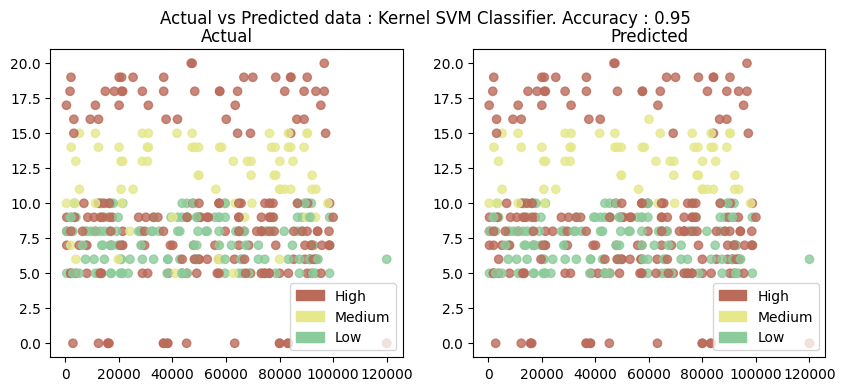

In [330]:
y_test = label_encoder.transform(y_test)
#y_pred_svm = label_encoder.transform(y_pred_svm)
two_d_compare(y_test,y_pred_svm,model_name)

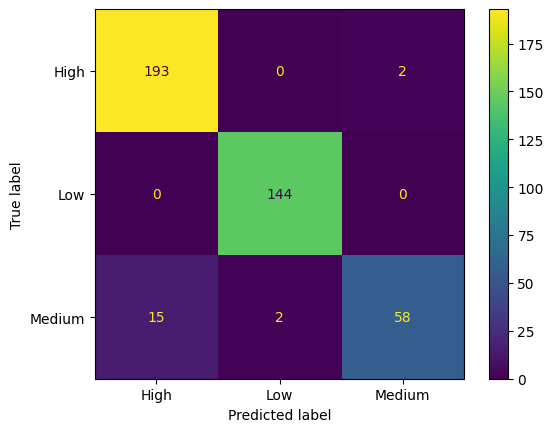

The classification report for the model : 

              precision    recall  f1-score   support

        High       0.93      0.99      0.96       195
         Low       0.99      1.00      0.99       144
      Medium       0.97      0.77      0.86        75

    accuracy                           0.95       414
   macro avg       0.96      0.92      0.94       414
weighted avg       0.96      0.95      0.95       414



In [331]:
y_test = label_encoder.inverse_transform(y_test)
y_pred_svm = label_encoder.inverse_transform(y_pred_svm)
model_metrics(y_test,y_pred_svm)

## [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html)

- It refers to the method of combining more than one machine learning algorithms to produce a better model

- **Homogenous Ensamble** : Combination of an algorithm with itself

- **Heterogenous Ensamble** : Combination of different algorithms

### Random Forest

- This model uses Bootstrapping to obtain random samples with replacement from the training data.

- Collection of such samples, form a dataset. It represents the original data, but it's not exactly same.

- Decision Trees are trained on various such datasets, using various subsets of features. These subsets of features are chosen randomly.

- The majority voted by these decision trees, is used to make a prediction.

- [`RandomForest Classifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

  Parmaeters:

  - n_estimators: int, default=100
  
    Number of trees in the forest.

  - max_depthint, default=None

    The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

  - bootstrapbool, default=True

    Whether bootstrap samples are used when building trees. If False, the whole dataset is used to build each tree.

  - random_stateint, RandomState instance or None, default=None

    Controls both the randomness of the bootstrapping of the samples used when building trees (if bootstrap=True) and the sampling of the features to consider when looking for the best split at each node (if max_features < n_features).

In [332]:
from sklearn.ensemble import RandomForestClassifier

model_name = "Random Forest Classifier"

randomForestClassifier = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

rfc_model = Pipeline(steps=[('preprocessorAll',preprocessorForAllColumns),('classifier', randomForestClassifier)])

rfc_model.fit(X_train,y_train)

y_pred_rfc = rfc_model.predict(X_test)

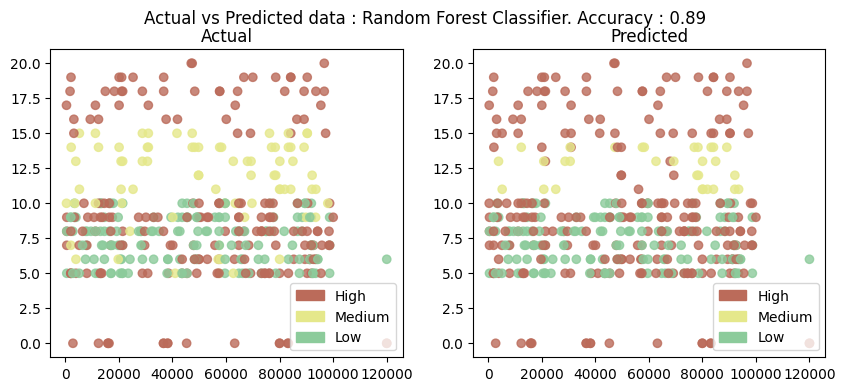

In [333]:
y_test = label_encoder.transform(y_test)
two_d_compare(y_test,y_pred_rfc,model_name)

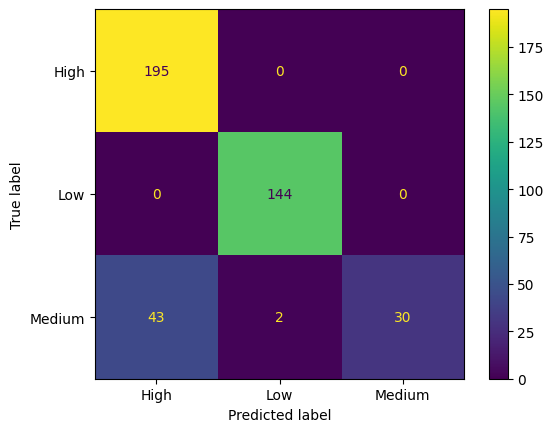

The classification report for the model : 

              precision    recall  f1-score   support

        High       0.82      1.00      0.90       195
         Low       0.99      1.00      0.99       144
      Medium       1.00      0.40      0.57        75

    accuracy                           0.89       414
   macro avg       0.94      0.80      0.82       414
weighted avg       0.91      0.89      0.87       414



In [334]:
y_test = label_encoder.inverse_transform(y_test)
y_pred_rfc = label_encoder.inverse_transform(y_pred_rfc)
model_metrics(y_test,y_pred_rfc)

### Gradient Boosted Trees

- They are based on the method called boosting, which involves training a model one after another based up on the outputs from the previous models.

- In gradient boosted trees, we calculate the error from the previous model, also known as residuals.

- We define another model that is trained on this residual.

- The resulting model is the sum of previous model and the model trained on residuals.

- This process is repeated until convergence.

## Conclusion

- Model performace differ based on different model parameters and use cases

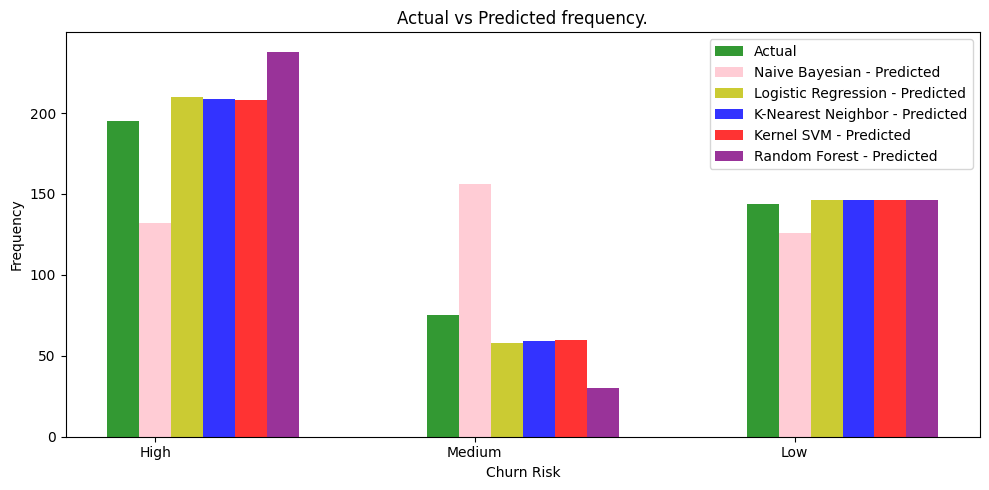

In [335]:
uniqueValues, occurCount = np.unique(y_test, return_counts=True)
frequency_actual = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_knn, return_counts=True)
frequency_predicted_knn = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_rfc, return_counts=True)
frequency_predicted_rfc = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_lrc, return_counts=True)
frequency_predicted_lrc = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_svm, return_counts=True)
frequency_predicted_svm = (occurCount[0],occurCount[2],occurCount[1])

uniqueValues, occurCount = np.unique(y_pred_nb, return_counts=True)
frequency_predicted_nb = (occurCount[0],occurCount[2],occurCount[1])

n_groups = 3
fig, ax = plt.subplots(figsize=(10,5))
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, frequency_actual, bar_width,
alpha=opacity,
color='g',
label='Actual')

rects2 = plt.bar(index + bar_width, frequency_predicted_nb, bar_width,
alpha=opacity,
color='pink',
label='Naive Bayesian - Predicted')

rects3 = plt.bar(index + bar_width*2, frequency_predicted_lrc, bar_width,
alpha=opacity,
color='y',
label='Logistic Regression - Predicted')

rects4 = plt.bar(index + bar_width*3, frequency_predicted_knn, bar_width,
alpha=opacity,
color='b',
label='K-Nearest Neighbor - Predicted')

rects5 = plt.bar(index + bar_width*4, frequency_predicted_svm, bar_width,
alpha=opacity,
color='red',
label='Kernel SVM - Predicted')

rects6 = plt.bar(index + bar_width*5, frequency_predicted_rfc, bar_width,
alpha=opacity,
color='purple',
label='Random Forest - Predicted')

plt.xlabel('Churn Risk')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted frequency.')
plt.xticks(index + bar_width, ('High', 'Medium', 'Low'))
plt.legend()

plt.tight_layout()
plt.show()